In [128]:
import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt
from AmortizedMixture import *
from helpers import *

In [64]:
NUM_STATES = 2
def prior_fun(num_states=NUM_STATES):
    return {
        'class_probabilities': np.random.dirichlet([1 for _ in range(num_states)]),
        'class_parameters': np.sort(np.random.normal(size=num_states))
    }

prior = bf.simulation.Prior(prior_fun = prior_fun)

In [65]:
def simulator_fun(params, num_obs=100, num_states=NUM_STATES):
    pi, mu = params.values()
    z = np.random.choice(a = [i for i in range(num_states)], size = num_obs, replace = True, p=pi)
    loc = mu[z]
    y = np.random.normal(loc=loc, size=(num_obs))
    return {
        "latents": z,
        "observables": y
    }
simulator = bf.simulation.Simulator(simulator_fun=simulator_fun)

In [66]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [67]:
inference_net = IndependentClassificator(num_outputs=2)

amortizer = AmortizedMixture(
    inference_net=inference_net,
    local_summary_net  = bf.networks.DeepSet(summary_dim=2),
    global_summary_net = bf.networks.DeepSet(summary_dim=10)
)
amortizer.is_conditional

False

In [68]:
def configurator(input_dict):
    parameters = np.array([np.concatenate([a['class_parameters'], a['class_probabilities']]) for a in input_dict['prior_draws']]).astype(np.float32)
    
    latents = [a['latents'] for a in input_dict['sim_data']]
    latents = tf.one_hot(np.array(latents), 2)

    observables = np.array([a['observables'] for a in input_dict['sim_data']])[..., np.newaxis, np.newaxis]

    return {
        "parameters": parameters,
        "latents": latents,
        "observables": observables
    }

In [69]:
d = model(3)
cd = configurator(d)
amortizer.compute_loss(cd)

<tf.Tensor: shape=(), dtype=float32, numpy=34.316174>

In [70]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=configurator)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [71]:
%%time
h = trainer.train_online(epochs=20, iterations_per_epoch=500, batch_size=64)

Training epoch 20: 100%|██████████| 500/500 [00:25<00:00, 19.79it/s, Epoch: 20, Iter: 500,Loss: 27.859,Avg.Loss: 27.809,LR: 1.49E-11]

CPU times: user 19min 48s, sys: 10min 59s, total: 30min 48s
Wall time: 8min 51s


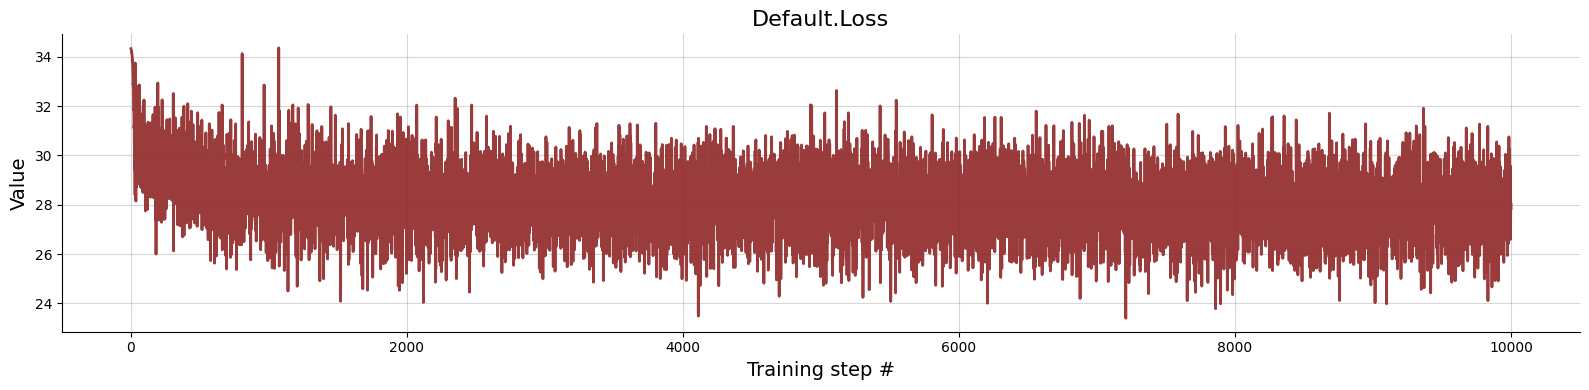

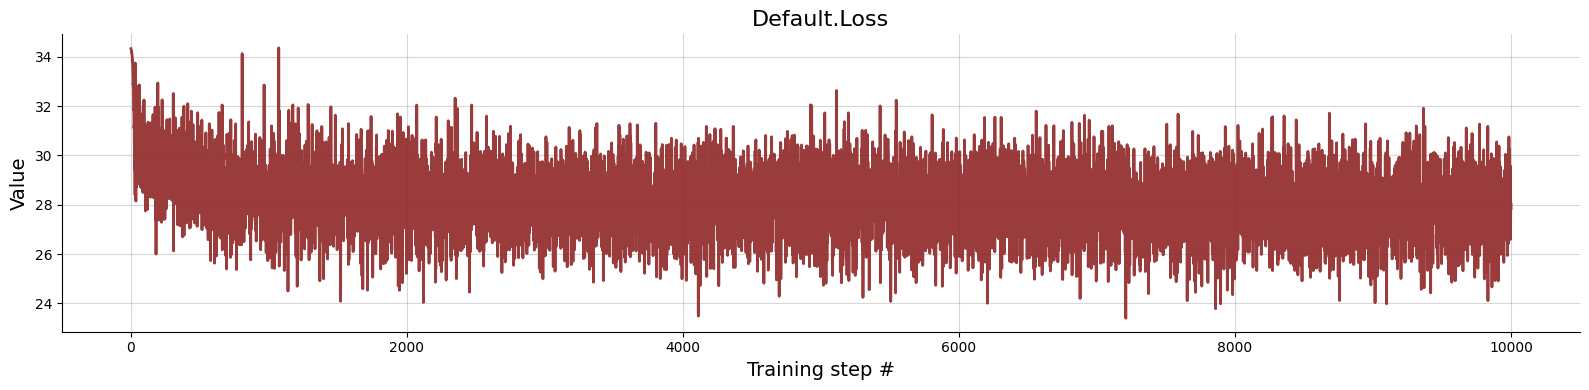

In [72]:
bf.diagnostics.plot_losses(h)

In [121]:
d = model(10)
cd = configurator(d)

In [127]:
p = amortizer.posterior_probs(cd)
classification_entropy(p)

accuracy(p, cd['latents'])
    

NameError: name 'np' is not defined

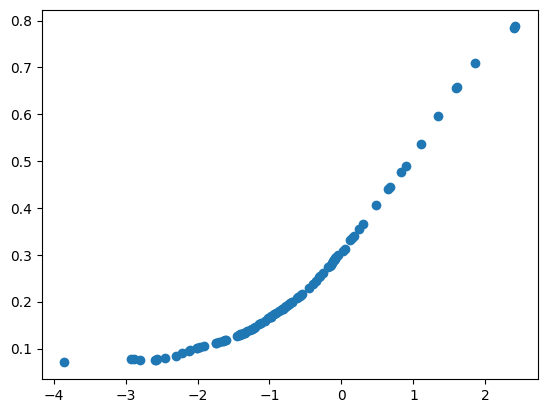

In [123]:
plt.scatter(cd['observables'][0, :, 0, 0], p[0,:,1])